# Define the system  

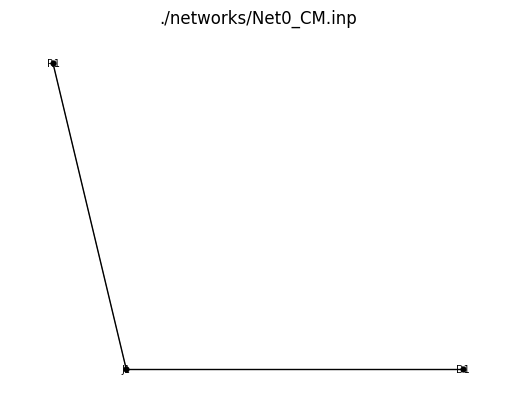

<Axes: title={'center': './networks/Net0_CM.inp'}>

In [18]:
import wntr
import wntr_quantum
import numpy as np
import matplotlib.pyplot as plt
# Create a water network model
inp_file = './networks/Net0_CM.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

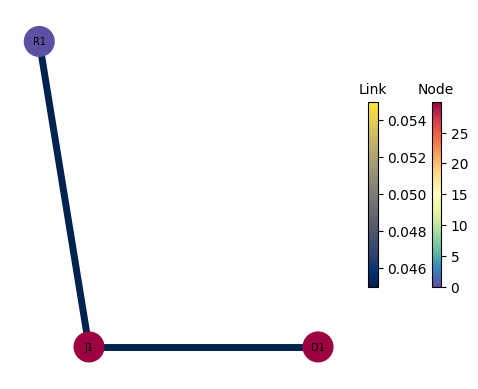

<Axes: >

In [19]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
flow_at_5hr = results.link['flowrate'].loc[0, :]
wntr.graphics.plot_network(wn, link_attribute=flow_at_5hr, 
                           node_attribute=pressure_at_5hr, 
                           node_size=500, 
                           link_width=5, 
                           node_labels=True,
                           link_cmap=plt.cm.cividis)

In [20]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 29.994, 29.988], dtype=float32)

## Run with the QUBO Polynomial Solver

In [21]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [22]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (4./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0, var_base_name="x")

nqbit = 5
step = (200/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 0.000000 => 200.000000 (res: 6.451613)
Flow Encoding : -4.000000 => -0.000000 | 0.000000 => 4.000000 (res: 0.129032)


Solve the system classically

In [23]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, bin_rep_sol, cvgd = net.classical_solutions()
ref_sol / ref_values

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1., 1., 1., 1.])

In [24]:
bin_rep_sol

[1, 1, [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]

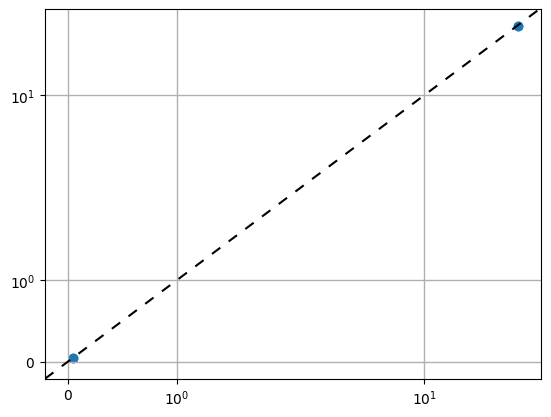

In [25]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values, encoded_ref_sol)
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

In [26]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.matrices = net.initialize_matrices(model)

In [27]:
from wntr_quantum.sampler.simulated_annealing import SimulatedAnnealing
# from wntr_quantum.sampler.simulated_annealing_parallel import SimulatedAnnealing
sampler = SimulatedAnnealing()

In [28]:
from qubops.qubops_mixed_vars import QUBOPS_MIXED
import sparse
net.qubo = QUBOPS_MIXED(net.mixed_solution_vector, {"sampler": sampler})
matrices = tuple(sparse.COO(m) for m in net.matrices)
net.qubo.qubo_dict = net.qubo.create_bqm(matrices, strength=0)

In [97]:
from wntr_quantum.sampler.step.full_random import RandomStep
from wntr_quantum.sampler.step.full_random import IncrementalStep
from wntr_quantum.sampler.step.full_random import ParallelIncrementalStep 

var_names = sorted(net.qubo.qubo_dict.variables)
net.qubo.create_variables_mapping()
# mystep = RandomStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables)
mystep = IncrementalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables, step_size=10)
# mystep = ParallelIncrementalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables, step_size=100)

# generate init sample

In [98]:
# from wntr_quantum.sampler.simulated_annealing import generate_random_valid_sample
# x = generate_random_valid_sample(net.qubo)
# x0 = list(x.values())

In [112]:
from wntr_quantum.sampler.simulated_annealing import modify_solution_sample
x = modify_solution_sample(net, bin_rep_sol, modify=['flows'])
x0 = list(x.values())

In [113]:
eref = net.qubo.energy_binary_rep(bin_rep_sol)

In [114]:
num_sweeps = 1000
Tinit = 1E1
Tfinal = 1E-1
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(1000))
# Tschedule = np.zeros(10000)

In [115]:
mystep.optimize_values = np.arange(4, 6)
res = sampler.sample(net.qubo.qubo_dict, init_sample=x0, Tschedule=Tschedule, take_step=mystep, save_traj=True, verbose=False)
mystep.verify_quadratic_constraints(res.res)

100%|██████████| 2000/2000 [00:00<00:00, 2479.48it/s]


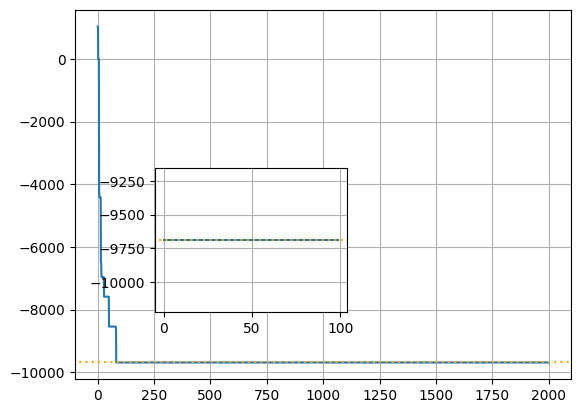

In [116]:
import matplotlib.pyplot as plt
eplt = res.energies

fig, ax1 = plt.subplots()

left, bottom, width, height = [0.25, 0.25, 0.3, 0.3]

ax1.plot(res.energies)
# ax1.plot(Tschedule)
ax1.axline((0, eref[0]), slope=0, color="orange", linestyle=(1, (1, 2)))
ax1.grid()
# ax1.set_yscale('symlog')

ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(eplt[-100:])
ax2.grid()
ax2.axline((0, eref[0]), slope=0, color="orange", linestyle=(1, (1, 2)))
# ax2.set_yscale('symlog')

In [117]:
idx_min = np.array([e for e in res.energies]).argmin()
# idx_min = -1
sol = res.trajectory[idx_min]
sol = net.qubo.decode_solution(np.array(sol))
sol = net.combine_flow_values(sol)
sol = net.convert_solution_to_si(sol)

In [118]:
print(eref[0], res.energies[idx_min])
print(eref[0] - res.energies[idx_min])

-9687.974189114439 -9687.974189114439
0.0


Text(0.5, 1.0, 'Pressure')

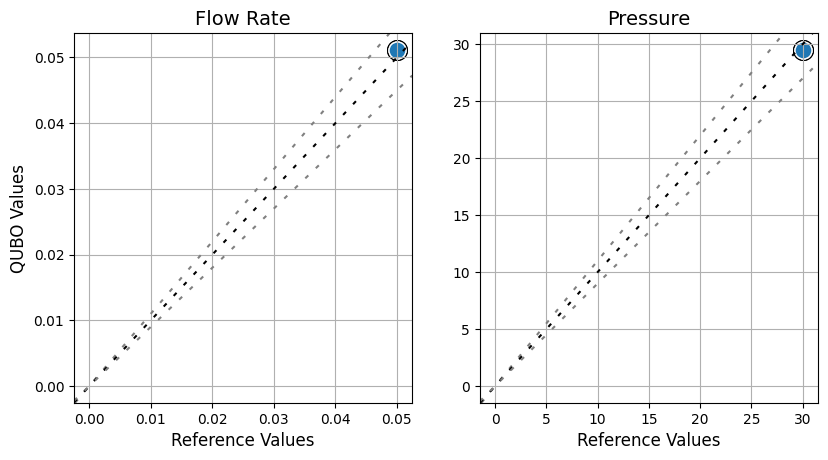

In [119]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = plt.figaspect(0.5))
ax1 = fig.add_subplot(121)

ax1.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))
ax1.grid()

ax1.scatter(ref_values[:2], encoded_ref_sol[:2], c='black', s=200, label='Best solution')
ax1.scatter(ref_values[:2], sol[:2], s=150, lw=1, edgecolors='w', label='Sampled solution')


ax1.set_xlabel('Reference Values', fontsize=12)
ax1.set_ylabel('QUBO Values', fontsize=12)
ax1.set_title('Flow Rate', fontsize=14)

ax2 = fig.add_subplot(122)

ax2.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))


ax2.scatter(ref_values[2:], encoded_ref_sol[2:], c='black', s=200, label='Best solution')
ax2.scatter(ref_values[2:], sol[2:], s=150, lw=1, edgecolors='w', label='Sampled solution')
ax2.grid()


ax2.set_xlabel('Reference Values', fontsize=12)
ax2.set_title('Pressure', fontsize=14)

In [61]:
def flatten_list(lst):
    out = []
    for elmt in lst:
        if not isinstance(elmt, list):
            out += [elmt]
        else:
            out += elmt
    return out

bin_rep_flat = flatten_list(bin_rep_sol)
xt_bin_rep_flat = net.qubo.extend_binary_representation(bin_rep_flat)
# xt_bin_rep_flat.values()

In [62]:
print(np.array(res.trajectory[idx_min])[net.qubo.index_variables])
print(np.array(bin_rep_flat))

[1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0]
[1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0]


In [63]:
xx = np.array(res.trajectory[idx_min])[net.qubo.index_variables]
net.qubo.energy_binary_rep(xx)

array([-9686.92])

0it [00:00, ?it/s]

/tmp/ipykernel_5700/711176967.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
32it [00:00, 69.06it/s]


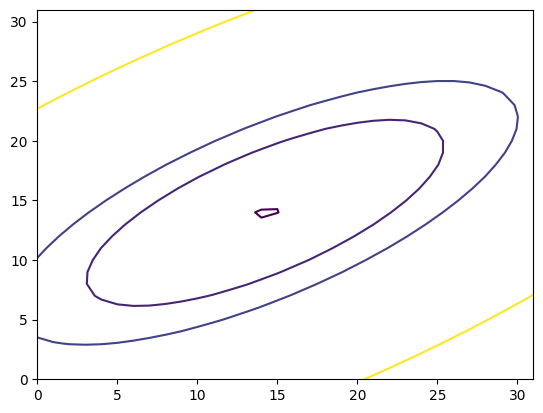

In [37]:
import itertools
from tqdm import tqdm
from copy import deepcopy
nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit
energies = np.zeros((2**nqbit, 2**nqbit))
i2 = 0
for data2 in tqdm(itertools.product([0, 1], repeat=nqbit)):
    i3 = 0
    for data3 in itertools.product([0, 1], repeat=nqbit):
        # print(list(data))
        mod_bin_rep_sol = deepcopy(bin_rep_sol)
        mod_bin_rep_sol[2] = list(data2)[::-1]
        mod_bin_rep_sol[3] = list(data3)[::-1]
        # x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
        # x0 = list(x.values())
        energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
        i3+=1
    i2+=1

# x, y = np.arange(2**nqbit), np.arange(2**nqbit)
# x,y = np.meshgrid(x,y)
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot_surface(x,y,energies)

# plt.imshow(energies- eref)
# plt.colorbar()

plt.contour(energies-eref, levels=[1e-2,1,2, 10])

0it [00:00, ?it/s]/tmp/ipykernel_5700/1779021354.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
32it [00:00, 82.58it/s]


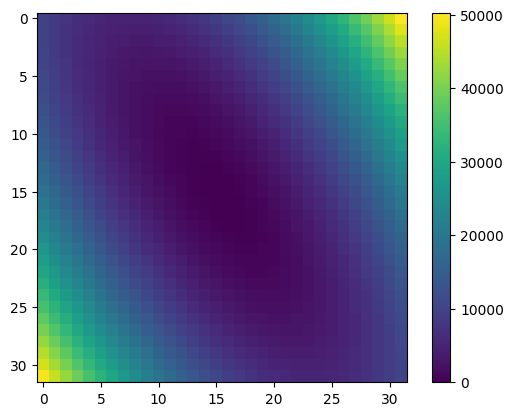

In [38]:
import itertools
from tqdm import tqdm
from copy import deepcopy

nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit
energies = np.zeros((2**nqbit, 2**nqbit))
i2 = 0
for data2 in tqdm(itertools.product([0, 1], repeat=nqbit)):
    i3 = 0
    for data3 in itertools.product([0, 1], repeat=nqbit):
        # print(list(data))
        mod_bin_rep_sol = deepcopy(bin_rep_sol)
        mod_bin_rep_sol[4] = list(data2)[::-1]
        mod_bin_rep_sol[5] = list(data3)[::-1]
        # x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
        # x0 = list(x.values())
        energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
        i3+=1
    i2+=1

# x, y = np.arange(2**nqbit), np.arange(2**nqbit)
# x,y = np.meshgrid(x,y)
# ax = plt.figure().add_subplot(projection='3d')
# ax.plot_surface(x,y,energies)
# plt.show()

plt.imshow(energies- eref)
plt.colorbar()

In [39]:
((energies-eref)==0).sum()

1

0it [00:00, ?it/s]/tmp/ipykernel_5700/321696615.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
32it [00:00, 1563.62it/s]


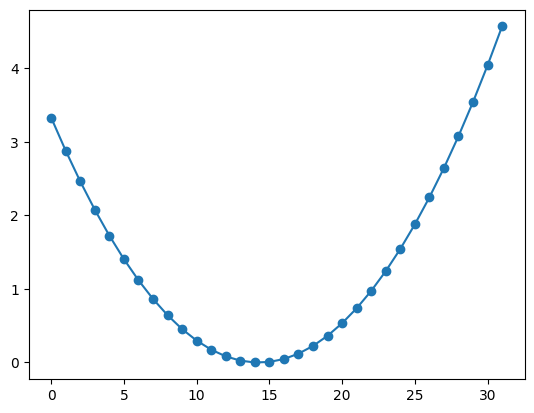

In [40]:
import itertools
from tqdm import tqdm

nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit
energies = np.zeros(2**nqbit)
i2 = 0
for data2 in tqdm(itertools.product([0, 1], repeat=nqbit)):

    mod_bin_rep_sol = deepcopy(bin_rep_sol)
    mod_bin_rep_sol[2] = list(data2)[::-1]
    # mod_bin_rep_sol[3] = list(data2)[::-1]
    energies[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)

    i2+=1
plt.plot(energies-eref, 'o-')

In [41]:
# import itertools
# from tqdm import tqdm
# from copy import deepcopy

# nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit
# energies = np.zeros((2**nqbit, 2**nqbit))

# for data1 in tqdm(itertools.product([0, 1], repeat=nqbit)):
#     for data2 in itertools.product([0, 1], repeat=nqbit):
#         for data3 in itertools.product([0, 1], repeat=nqbit):
#             for data4 in itertools.product([0, 1], repeat=nqbit):
#                 # print(list(data))
#                 mod_bin_rep_sol = deepcopy(bin_rep_sol)
#                 mod_bin_rep_sol[2] = list(data1)[::-1]
#                 mod_bin_rep_sol[3] = list(data2)[::-1]
#                 mod_bin_rep_sol[4] = list(data3)[::-1]
#                 mod_bin_rep_sol[5] = list(data4)[::-1]
#                 # x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
#                 # x0 = list(x.values())
#                 energies = net.qubo.energy_binary_rep(mod_bin_rep_sol)
#                 if energies <= eref:
#                     print(energies-eref)
#                     print(data1)
#                     print(data2)
#                     print(data3)
#                     print(data4)




# Embed the problem

In [42]:
import dwave_networkx as dnx
from minorminer import find_embedding
from dwave.embedding import embed_qubo, majority_vote, chain_break_frequency

In [43]:
net.qubo.qubo_dict.to_qubo()[0]

{('x_002_001', 'x_004_001'): -0.9113462377164281,
 ('x_004_001*x_002_001', 'x_004_001'): 0.0,
 ('x_004_001*x_002_001', 'x_002_001'): 0.0,
 ('x_004_004', 'x_004_001'): 0.5328034021738732,
 ('x_004_004', 'x_002_001'): -7.290769901731425,
 ('x_004_004', 'x_004_001*x_002_001'): -4.440892098500626e-16,
 ('x_004_004*x_002_001', 'x_002_001'): 0.0,
 ('x_004_004*x_002_001', 'x_004_004'): 0.0,
 ('x_003_003', 'x_004_001'): -0.13319458896982309,
 ('x_003_003', 'x_004_001*x_002_001'): 0.26638917793964617,
 ('x_003_003', 'x_004_004'): -1.0655567117585847,
 ('x_003_003', 'x_004_004*x_002_001'): 2.1311134235171694,
 ('x_003_003', 'x_001_001'): -0.6350934832009412,
 ('x_001_001*x_003_003', 'x_004_001'): 0.26638917793964617,
 ('x_001_001*x_003_003', 'x_004_001*x_002_001'): -0.5327783558792923,
 ('x_001_001*x_003_003', 'x_004_004'): 2.1311134235171694,
 ('x_001_001*x_003_003', 'x_004_004*x_002_001'): -4.262226847034339,
 ('x_001_001*x_003_003', 'x_001_001'): 0.0,
 ('x_001_001*x_003_003', 'x_003_003'): 0.

In [44]:
# target_graph = dnx.pegasus_graph(6)
# embedding = find_embedding(net.qubo.qubo_dict.to_qubo()[0], target_graph)

In [45]:
# embedding

In [46]:
# dnx.draw_pegasus(dnx.pegasus_graph(6),  node_size=2, width=0.1)

In [47]:
# dnx.draw_pegasus_embedding(target_graph, embedding, node_size=10, width=0.25)